In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [5]:
bank = pd.read_csv('bank-additional-full.csv', delimiter=';')

In [6]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
bank.y.value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

In [8]:
tf.__version__

'2.15.0'

In [9]:
bank['y'] = bank['y'].apply(lambda x: 1 if x == 'yes' else 0)

In [10]:
bank['y'].value_counts()

y
0    36548
1     4640
Name: count, dtype: int64

In [11]:
bank['target'] = bank['y'] 

In [12]:
bank.drop(['y'], axis=1, inplace=True)

In [13]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [14]:
train, val, test = np.split(bank.sample(frac=1), [int(0.75*len(bank)), int(0.85*len(bank))])
print(len(train), 'training examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


30891 training examples
4118 validation examples
6179 test examples


/home/andre/Documents/Projects/MLLab/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [15]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  df = dataframe.copy()
  labels = df.pop('target')
  df = {key: value.values[:,tf.newaxis] for key, value in dataframe.items()}
  ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [16]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [17]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    index = layers.StringLookup(max_tokens=max_tokens)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
    index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  return lambda feature: encoder(index(feature))


In [18]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)


2024-02-27 21:40:47.544811: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-27 21:40:47.545320: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [19]:
numerical_feats = list(bank.select_dtypes(include=[np.number]).drop('target', axis=1).columns)

categorical_feats = list(bank.select_dtypes(exclude=[np.number]).columns)

In [20]:
print(numerical_feats)
print(categorical_feats)

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


In [21]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical_feats:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)


In [22]:
categorical_feats = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for header in categorical_feats:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [23]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)


In [24]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [25]:
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8207 - loss: 1.4695 - val_accuracy: 0.8919 - val_loss: 0.5683
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8912 - loss: 0.5417 - val_accuracy: 0.9060 - val_loss: 0.3979
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8966 - loss: 0.3629 - val_accuracy: 0.7824 - val_loss: 0.7866
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8431 - loss: 0.6745 - val_accuracy: 0.8424 - val_loss: 0.6873
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8509 - loss: 0.6840 - val_accuracy: 0.8657 - val_loss: 0.5780
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8624 - loss: 0.6029 - val_accuracy: 0.8793 - val_loss: 0.4721
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8748 - loss: 0.5000 - val_accuracy: 0.8934 - val_loss: 0.3651
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8916 - loss: 0.4007 - val_accuracy: 0.

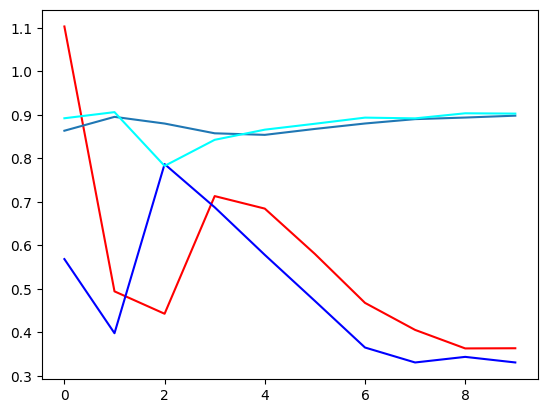

In [26]:
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')

In [27]:
model.evaluate(test_ds)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8940 - loss: 0.3570


[0.3513844609260559, 0.8939958214759827]

### Test 2

In [28]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
x = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8863 - loss: 0.3545 - val_accuracy: 0.9174 - val_loss: 0.2033
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9107 - loss: 0.1971 - val_accuracy: 0.9174 - val_loss: 0.1928
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9090 - loss: 0.1970 - val_accuracy: 0.9186 - val_loss: 0.1886
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9110 - loss: 0.1890 - val_accuracy: 0.9177 - val_loss: 0.1876
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9095 - loss: 0.1919 - val_accuracy: 0.9160 - val_loss: 0.1858
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9144 - loss: 0.1854 - val_accuracy: 0.9167 - val_loss: 0.1854
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9130 - loss: 0.1846 - val_accuracy: 0.9177 - val_loss: 0.1855
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9154 - loss: 0.1816 - val_accuracy: 0.

In [29]:
model.evaluate(test_ds)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9117 - loss: 0.1863


[0.18440021574497223, 0.9117980003356934]

### Test 3


In [34]:
import keras
from keras.utils import plot_model

In [30]:
all_features = tf.keras.layers.concatenate(encoded_features)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
x1 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x1)


x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(all_features)
x2 = tf.keras.layers.Dense(32, activation="swish", kernel_initializer='he_normal')(x2)


combined_features = tf.keras.layers.concatenate([x2, x1])

output = tf.keras.layers.Dense(1, activation='sigmoid')(combined_features)

model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8124 - loss: 0.4209 - val_accuracy: 0.9133 - val_loss: 0.2158
Epoch 2/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 0.2096 - val_accuracy: 0.9150 - val_loss: 0.1983
Epoch 3/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9093 - loss: 0.1978 - val_accuracy: 0.9169 - val_loss: 0.1899
Epoch 4/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9092 - loss: 0.1928 - val_accuracy: 0.9179 - val_loss: 0.1862
Epoch 5/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9135 - loss: 0.1848 - val_accuracy: 0.9153 - val_loss: 0.1894
Epoch 6/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9112 - loss: 0.1850 - val_accuracy: 0.9186 - val_loss: 0.1859
Epoch 7/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9138 - loss: 0.1841 - val_accuracy: 0.9172 - val_loss: 0.1852
Epoch 8/10
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9157 - loss: 0.1819 - val_accuracy: 0.

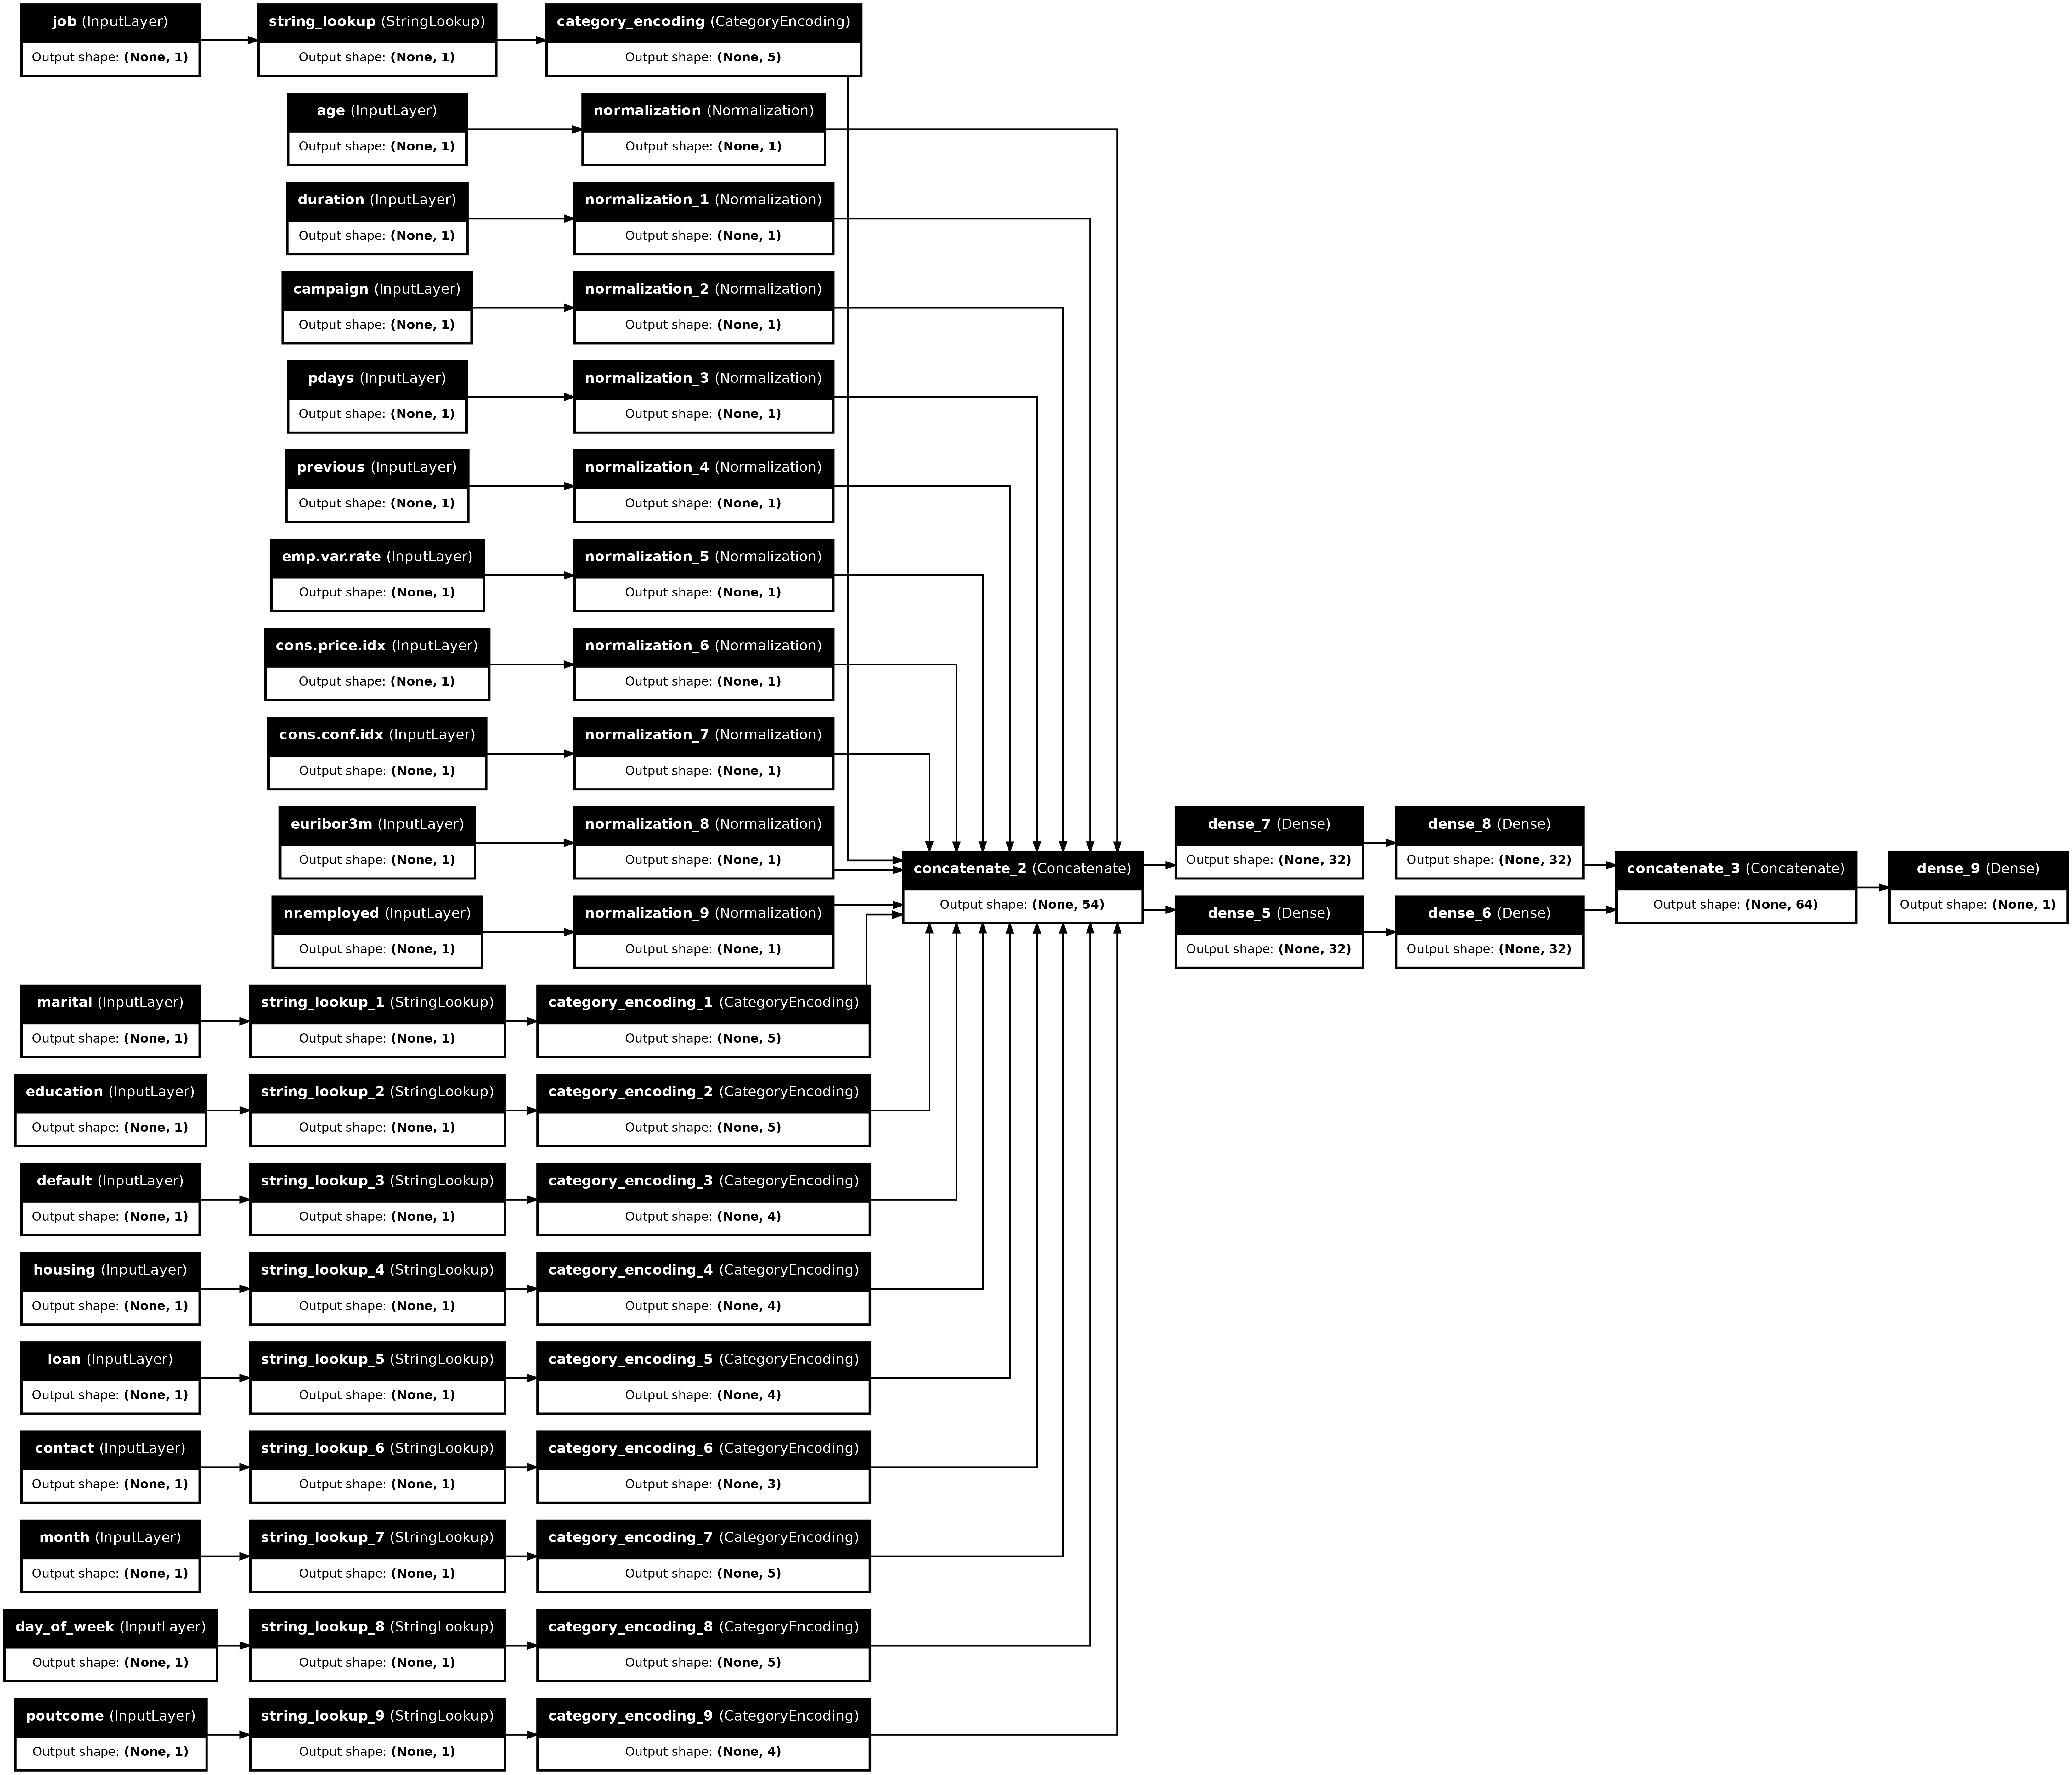

In [36]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='LR')

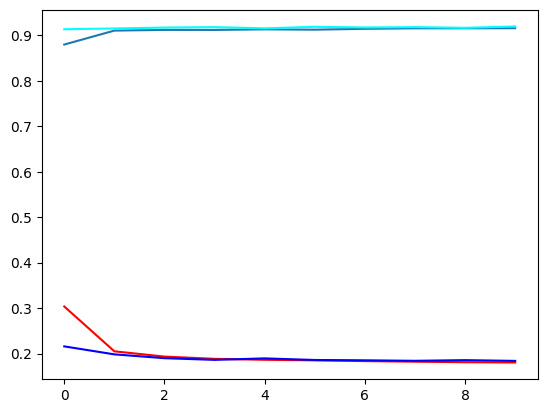

In [37]:
plt.plot(history.history['loss'], label='Loss Training', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')